# CTA 2D source fitting with Sherpa


## Prepare sky images
We first create counts, exposure, background and PSF maps, following the steps under "Make sky images" in the cta_data_analysis Notebook:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.units as u
from gammapy.image import SkyImage, IACTBasicImageEstimator
from gammapy.background import RingBackgroundEstimator
from gammapy.data import DataStore

from regions import CircleSkyRegion
import numpy as np

# Create reference image: 6x6 deg FOV centered on (l,b) = (300,0)
target_position = SkyCoord(300, 0, unit='deg', frame='galactic')

xref = target_position.galactic.l.value
yref = target_position.galactic.b.value

ref_image = SkyImage.empty(
    nxpix=300, nypix=300, binsz=0.02,
    xref=xref, yref=yref,
    proj='TAN', coordsys='GAL')

We initially define no exclusion regions for the background estimation, as we have not yet determined the positions of sources in the field of view:

Name: None
Data shape: (300, 300)
Data type: bool
Data unit: 
Data mean: 9.780e-01
WCS type: ['GLON-TAN', 'GLAT-TAN']



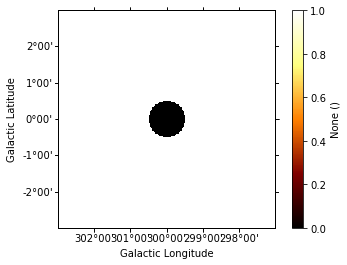

In [8]:
on_region = CircleSkyRegion(center=SkyCoord(300, 0, unit='deg',
                            frame='galactic'), radius=0.5 * u.deg)
excl_mask = ref_image.region_mask(on_region)
excl_mask.data = np.invert(excl_mask.data)

# excl_mask = ref_image
# excl_mask.data = ref_image.data == 0

print(excl_mask)
excl_mask.plot(add_cbar=True)

bkg_estimator = RingBackgroundEstimator(
    r_in=0.5 * u.deg,
    width=0.2 * u.deg)

Set the map energy threshold at 300 GeV, which seems a good compromise for source detection sensitivity: with a low threshold the background is more important, but too high a threshold yields limited source statistics.

In [9]:
image_estimator = IACTBasicImageEstimator(
    reference=ref_image,
    emin=0.3 * u.TeV,
    emax=100 * u.TeV,
    offset_max=4 * u.deg,
    background_estimator=bkg_estimator,
    exclusion_mask=excl_mask)

OBS_ID
------
110040
110122
110120
110081
110078
110121
110079
110080
110038
110039 observations within radius 4 deg


/Users/facero/Documents/Work/Program/gammapy/gammapy/gammapy/cube/core.py:85: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(self.data.value)
/Users/facero/Documents/Work/Program/Anaconda/envs/cta/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2444: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


counts


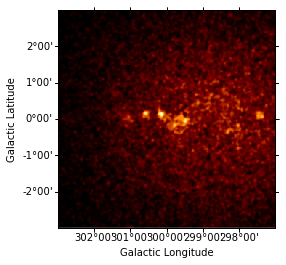

exposure


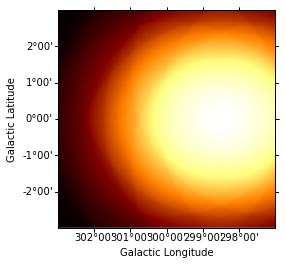

background


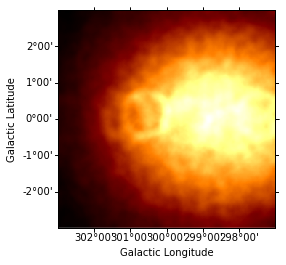

excess


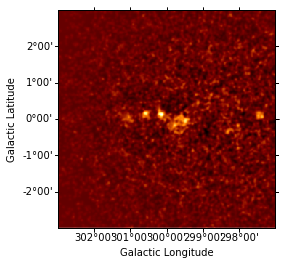

flux


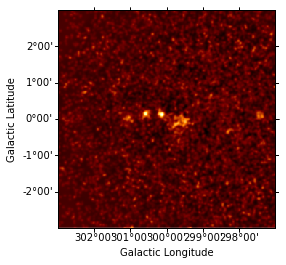

psf


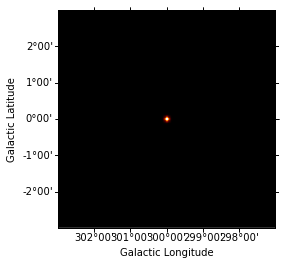

In [10]:
# Should work if the environment variable CTADATA is set;
# otherwise, change the path to your index file directory.
INDX_DIR = '$CTADATA/index/gps'

data_store = DataStore.from_dir(INDX_DIR)

ras = data_store.obs_table['RA_PNT'] * u.deg
decs = data_store.obs_table['DEC_PNT'] * u.deg
pointings = SkyCoord(ras, decs, frame='icrs' )
dists = pointings.separation(target_position)
obs_id = data_store.obs_table['OBS_ID'][(dists < 4 * u.deg)]
print((obs_id), "observations within radius 4 deg")

obslist = data_store.obs_list(obs_id)
images = image_estimator.run(obslist)

for i,im in enumerate(images):
    print(images.names[i])
    im.smooth(radius=3).plot() ; plt.show()

Now save the obtained images as FITS files for import into Sherpa:

In [11]:
images['counts']    .write("G300-0_test_counts.fits", clobber=True)
images['exposure']  .write("G300-0_test_exposure.fits", clobber=True)
images['background'].write("G300-0_test_background.fits", clobber=True)

# Hack to convert PSF data from an array of Quantity's to a float array:
images['psf'].data = images['psf'].data.value
images['psf']       .write("G300-0_test_psf.fits", clobber=True)


## Fit sources with Sherpa
Set up Sherpa to fit the counts map, loading the ancillary images for subsequent use. A relevant test statistic for data with Poisson fluctuations is the one proposed by Cash (1979). The simplex (or Nelder-Mead) fitting algorithm is a good compromise between efficiency and robustness. The source fit is best performed in pixel coordinates.

In [13]:
import sherpa.astro.ui as sh
from gammapy.image import SkyImage
from regions.core.pixcoord import PixCoord
from regions.shapes.circle import CirclePixelRegion

sh.set_stat("cash")
sh.set_method("simplex")
sh.load_image("G300-0_test_counts.fits")
sh.set_coord("logical")

sh.load_table_model("expo", "G300-0_test_exposure.fits")
sh.load_table_model("bkg",  "G300-0_test_background.fits")
sh.load_psf        ("psf",  "G300-0_test_psf.fits")

In principle one might first want to fit the background amplitude. However the background estimation method already yields the correct normalization, so we freeze the background amplitude to unity instead of adjusting it. The (smoothed) residuals from this background model are then computed and shown.

(<matplotlib.figure.Figure at 0x1235981d0>,
 <matplotlib.colorbar.Colorbar at 0x11e74ad50>)

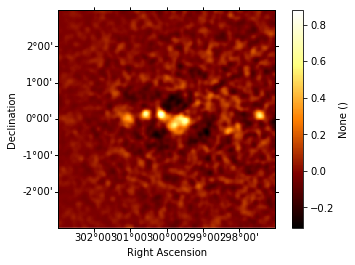

In [20]:
sh.set_full_model(bkg)
bkg.ampl = 1
sh.freeze(bkg)

sh.save_resid("resid.fits", clobber=True)
resid = SkyImage.read("resid.fits")
resid_smo6 = resid.smooth(radius = 6)
resid_smo6.plot(add_cbar=True)

### Find and fit the brightest source
We then find the position of the maximum in the (smoothed) residuals map, and fit a (symmetrical) Gaussian source with that initial position:

In [21]:
maxcoord = resid_smo6.lookup_max()
maxpix = resid_smo6.wcs_skycoord_to_pixel(maxcoord[0])
sh.set_full_model(bkg + psf(sh.gauss2d.g0) * expo) # creates g0 as a gauss2d instance
g0.xpos = maxpix[0]
g0.ypos = maxpix[1]
sh.freeze(g0.xpos, g0.ypos) # fix the position in the initial fitting step

expo.ampl = 1e-9 # fix exposure amplitude so that typical exposure is of order unity
sh.freeze(expo)
sh.thaw(g0.fwhm, g0.ampl) # in case frozen in a previous iteration

g0.fwhm = 10 # give some reasonable initial values
g0.ampl = maxcoord[1]
sh.fit() # Performs the fit; this takes a little time.

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 97173.3
Final fit statistic   = 96793.5 at function evaluation 228
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 379.79
   g0.fwhm        5.64076     
   g0.ampl        0.456248    


Fit all parameters of this Gaussian component, fix them and re-compute the residuals map.

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96793.5
Final fit statistic   = 96793.1 at function evaluation 288
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 0.33221
   g0.fwhm        5.53179     
   g0.xpos        142         
   g0.ypos        156.299     
   g0.ampl        0.470348    


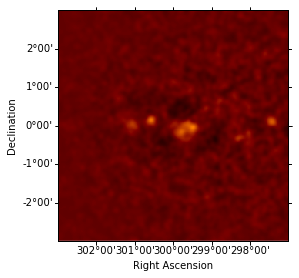

In [22]:
sh.thaw(g0.xpos, g0.ypos)
sh.fit()
sh.freeze(g0)

sh.save_resid("resid.fits", clobber=True)
resid = SkyImage.read("resid.fits")
resid_smo6 = resid.smooth(radius = 6)
resid_smo6.show(vmin = -0.5, vmax = 2)

### Iteratively find and fit additional sources
Instantiate additional Gaussian components, and use them to iteratively fit sources, repeating the steps performed above for component g0. (The residuals map is shown after each additional source included in the model.) This takes some time...

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96793.1
Final fit statistic   = 96669.1 at function evaluation 265
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 124.035
   g1.fwhm        17.1351     
   g1.ampl        0.105847    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96669.1
Final fit statistic   = 96626.2 at function evaluation 345
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 42.9195
   g1.fwhm        18.4943     
   g1.xpos        166.606     
   g1.ypos        144.67      
   g1.ampl        0.116481    


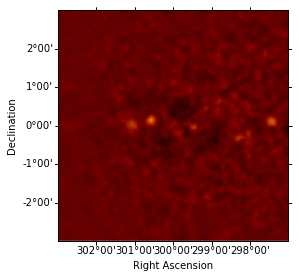

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96626.2
Final fit statistic   = 96546.2 at function evaluation 244
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 79.9373
   g2.fwhm        5.15295     
   g2.ampl        0.46622     
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96546.2
Final fit statistic   = 96543.3 at function evaluation 293
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 2.94368
   g2.fwhm        5.10458     
   g2.xpos        120.874     
   g2.ypos        156.917     
   g2.ampl        0.481783    


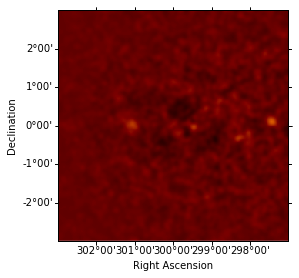

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96543.3
Final fit statistic   = 96488.1 at function evaluation 254
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 55.221
   g3.fwhm        6.54721     
   g3.ampl        0.222759    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96488.1
Final fit statistic   = 96483.6 at function evaluation 288
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 4.44935
   g3.fwhm        6.52534     
   g3.xpos        277.705     
   g3.ypos        155.145     
   g3.ampl        0.234563    


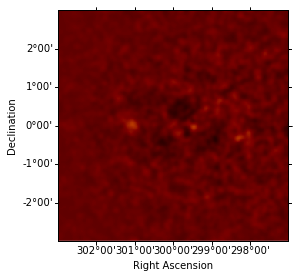

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96483.6
Final fit statistic   = 96426.3 at function evaluation 262
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 57.2814
   g4.fwhm        11.2072     
   g4.ampl        0.147998    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96426.3
Final fit statistic   = 96425.8 at function evaluation 318
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 0.531014
   g4.fwhm        11.5006     
   g4.xpos        95.3634     
   g4.ypos        150.589     
   g4.ampl        0.14508     


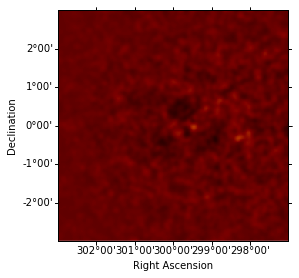

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96425.8
Final fit statistic   = 96407.6 at function evaluation 271
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 18.2506
   g5.fwhm        2.95463     
   g5.ampl        0.505805    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96407.6
Final fit statistic   = 96407.5 at function evaluation 296
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 0.071752
   g5.fwhm        2.97226     
   g5.xpos        176.189     
   g5.ypos        148.122     
   g5.ampl        0.499442    


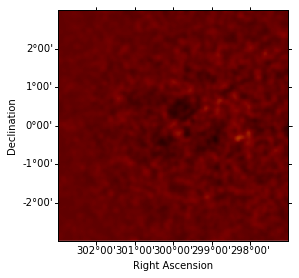

In [23]:
for i in range(1,6) :
    sh.create_model_component('gauss2d', 'g'+str(i))
gs = [g0, g1, g2, g3, g4, g5]
sh.set_full_model(bkg + psf(g0+g1+g2+g3+g4+g5) * expo)

for i in range(1, len(gs)) :
    gs[i].ampl = 0   # initialize components with fixed, zero amplitude
    sh.freeze(gs[i])

for i in range(1, len(gs)) :
    maxcoord = resid_smo6.lookup_max()
    maxpix = resid_smo6.wcs_skycoord_to_pixel(maxcoord[0])
    gs[i].xpos = maxpix[0]
    gs[i].ypos = maxpix[1]
    gs[i].fwhm = 10
    gs[i].fwhm = maxcoord[1]

    sh.thaw(gs[i].fwhm)
    sh.thaw(gs[i].ampl)
    sh.fit()

    sh.thaw(gs[i].xpos)
    sh.thaw(gs[i].ypos)
    sh.fit()
    sh.freeze(gs[i])

    sh.save_resid("resid.fits", clobber=True)
    resid = SkyImage.read("resid.fits")
    resid_smo6 = resid.smooth(radius = 6)
    resid_smo6.show(vmin = -0.5, vmax = 2)

The criterion for a significant source detection is typically that it should improve the test statistic by at least 25 or 30. The last excess fitted (g5) thus not a significant source:

In [24]:
ampl  = g5.ampl.val # save g5 fitted amplitude value
g5.ampl = 0
stati = sh.get_stat_info()[0].statval # value of statistic without g5 in model
g5.ampl = ampl
statf = sh.get_stat_info()[0].statval # value of statistic with g5
delstat = stati - statf
print 'Del_stat(g5) = ', delstat

Del_stat(g5) =  18.3223835633
